In [1]:
import pandas as pd
from pathlib import Path

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir("../input"))

import multiprocessing as mp
# Any results you write to the current directory are saved as output.


['train.zip', 'test_images', 'sample_submission.csv.zip', 'description.md', 'test_images.zip', 'train_images', 'train_images.zip', 'test.zip', 'sample_submission.csv', 'test.csv.zip', 'train.csv', 'train.csv.zip', 'test.csv', 'aptos2019-blindness-detection']


In [3]:
directory = "../input/test_preprocessed/"
if not os.path.exists(directory):
    os.makedirs(directory)


In [4]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
DATA_ROOT = '../input/aptos2019-blindness-detection/test_images/'
OUTPUT_DIR = directory
SIZE = 512


In [6]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def preprocess_image(df, run_root=DATA_ROOT, out_root=OUTPUT_DIR, size=SIZE):
    df = df.reset_index()
    for i in tqdm(range(df.shape[0])):
        item = df.iloc[i]
        path = run_root+item.id_code+'.png'
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = circle_crop(img)
        img = crop_image_from_gray(img)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img=cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), 10) ,-4 ,128)
        cv2.imwrite(OUTPUT_DIR + item.id_code + '.png',img) 


In [7]:
n_cpu = mp.cpu_count()
pool = mp.Pool(n_cpu)
n_cnt = df.shape[0] // n_cpu
dfs = [df.iloc[n_cnt*i:n_cnt*(i+1)] for i in range(n_cpu)]
dfs[-1] = df.iloc[n_cnt*(n_cpu-1):] 
res = pool.map(preprocess_image, [x_df for x_df in dfs])
pool.close()


 91%|█████████ | 10/11 [00:11<00:00,  1.06it/s]

100%|██████████| 26/26 [00:14<00:00,  1.85it/s]


(1050, 1050, 3) (512, 512, 3)


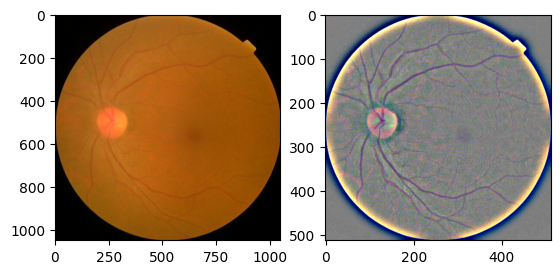

In [8]:
fig, axes = plt.subplots(1, 2)
img_raw = cv2.imread(DATA_ROOT + df.iloc[0].id_code + '.png')
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

img = cv2.imread(OUTPUT_DIR + df.iloc[0].id_code + '.png', cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

axes[0].imshow(img_raw)
axes[1].imshow(img)
print(img_raw.shape, img.shape)


In [9]:
df.to_csv('submission.csv', index=None)
if os.path.exists(directory):
    !rm -r '../input/test_preprocessed'


In [10]:
print(os.listdir("../input"))


['train.zip', 'test_images', 'sample_submission.csv.zip', 'description.md', 'test_images.zip', 'train_images', 'train_images.zip', 'test.zip', 'sample_submission.csv', 'test.csv.zip', 'train.csv', 'train.csv.zip', 'test.csv', 'aptos2019-blindness-detection']
